## DSC540 project milestone 2
#### Author: Xin Tang
### date: 1/15/2024

#### Perform at least 5 data transformation and/or cleansing steps to your flat file data

###### the flat data file I chose is an Excel file with 2 tabs, which contains depature and arrival info respectively. For what my project is concerning. I would like to use only departure tab. 

In [1]:
# import related package
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re

###### Step 1. import data as a dataframe

In [2]:
tang_df = pd.read_excel("aus-flight.xlsx",sheet_name='departure')

###### Step 2. check the data for unique values(duplicate) and empty input

In [3]:
cols = tang_df.columns
def Unique_Values():
    for i in np.arange(0,len(cols)):
        print('There are {} of unique values in {} column out of {}'.format(tang_df[cols[i]].nunique(), cols[i], len(tang_df)))
print(Unique_Values())
#tang_df.info()
print('variables with NA values', tang_df.isna().sum())

There are 1 of unique values in YEAR column out of 7517
There are 3 of unique values in MONTH column out of 7517
There are 31 of unique values in DAY column out of 7517
There are 7 of unique values in DAY_OF_WEEK column out of 7517
There are 11 of unique values in AIRLINE column out of 7517
There are 509 of unique values in FLIGHT_NUMBER column out of 7517
There are 2068 of unique values in TAIL_NUMBER column out of 7517
There are 1 of unique values in ORIGIN_AIRPORT column out of 7517
There are 36 of unique values in DESTINATION_AIRPORT column out of 7517
There are 318 of unique values in SCHEDULED_DEPARTURE column out of 7517
There are 995 of unique values in DEPARTURE_TIME column out of 7517
There are 233 of unique values in DEPARTURE_DELAY column out of 7517
There are 55 of unique values in TAXI_OUT column out of 7517
There are 1007 of unique values in WHEELS_OFF column out of 7517
There are 121 of unique values in SCHEDULED_TIME column out of 7517
There are 246 of unique values in

In [7]:
tang_df.head(2)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,OO,4986,N719SK,AUS,LAX,538,...,654.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,1178,N573AA,AUS,DFW,550,...,649.0,-1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


###### I have a few observations on the data :
      1. the data has too many columns, I only want to find out the data, airline, flight number and delay info. so I will narrow it down.
      2. for the columns I am concerning, the DEPARTURE_DELAY has empty cell. need to find out if empty mean no delay or missing info.
      3. duplicate values are not a concern. as long as they represent different flights or same flight on different days. 
      4. need to make sure the city name and airline code are all upper case. 


###### Step 3. make dataframe more readable by removing columns not useful

In [4]:
# out of the 31 columns, pick essential columns.
# I will keep month, day, airline, flight_number, origin_airport, destination_airport, departure time and departure delay, as well cancelled only.

new_df = tang_df[['MONTH','DAY','AIRLINE','FLIGHT_NUMBER','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DEPARTURE_TIME','DEPARTURE_DELAY','CANCELLED']]
new_df.head()

,MONTH,DAY,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_TIME,DEPARTURE_DELAY,CANCELLED
0,1,1,OO,4986,AUS,LAX,535.0,-3.0,0
1,1,1,AA,1178,AUS,DFW,548.0,-2.0,0
2,1,1,B6,794,AUS,JFK,559.0,-1.0,0
3,1,1,OO,6235,AUS,SFO,556.0,-4.0,0
4,1,1,UA,572,AUS,IAH,658.0,28.0,0


###### Step 4. check casing and consistence of data

In [23]:
#check if origin airport codes are all upper case
#check if airline names are all upper case
# from check above, airport and airline code are not empty for all records.
print('it is {a} that all airline name is upper case'.format(a = new_df['AIRLINE'].str.isupper().all()))
print('it is {b} that all origin airport name is upper case'.format(b = new_df['ORIGIN_AIRPORT'].str.isupper().all()))
print('all observations has airline and airport info')

it is True that all airline name is upper case
it is True that all origin airport name is upper case
all observations has airline and airport info


###### Step 5. find unreasonble data and remove them: first remove the flight cancelled but still have delay time.

In [5]:
#if a flight is cancelled, there should have no depature time.
# check any cancelled flight with a numeric value in depature time
cancelled_df =new_df[new_df['CANCELLED']==1]
#cancelled_df.head(12)
wired = cancelled_df[cancelled_df['DEPARTURE_TIME'].values>1]
wired.head()   

,MONTH,DAY,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_TIME,DEPARTURE_DELAY,CANCELLED
360,1,4,UA,572,AUS,IAH,848.0,23.0,1
4884,2,14,WN,4158,AUS,BWI,1925.0,25.0,1
6105,2,25,OO,5532,AUS,LAX,1941.0,17.0,1


In [6]:
# create new df without weird departure info
print(new_df.shape)
clean_df =new_df.drop([360, 4884, 6105])
clean_df.shape

(7517, 9)


(7514, 9)

###### Step 6 find outliner on flight delay times

{'whiskers': [<matplotlib.lines.Line2D at 0x205f9967390>,
 'caps': [<matplotlib.lines.Line2D at 0x205f9978090>,
 'boxes': [<matplotlib.lines.Line2D at 0x205f9966990>],
 'medians': [<matplotlib.lines.Line2D at 0x205f99797d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x205f9979fd0>],
 'means': []}

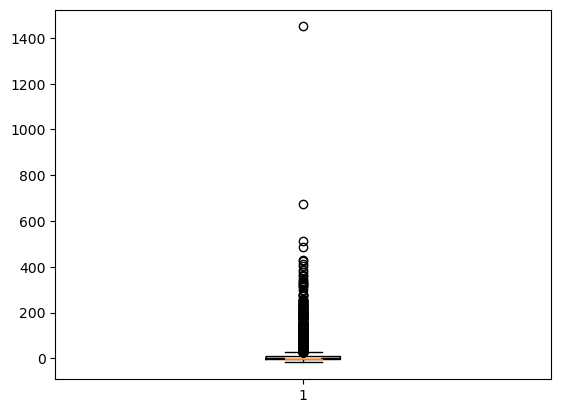

In [88]:
#do a box plot of delay.
# first need to select flight not cancelled, since cancelled flight has no delay info filled
not_cancelled_df =clean_df[clean_df['CANCELLED']==0]

plt.boxplot(not_cancelled_df.DEPARTURE_DELAY, notch=True)

###### Step 7. rename the header "DEPARTURE_DELAY' to "DELAY" so reduce time to type

In [7]:
clean_df.rename(columns = {'DEPARTURE_DELAY':'DELAY'}, inplace = True) 
clean_df.head()
# now if the flight is cancelled, the delay time is empty. 

,MONTH,DAY,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_TIME,DELAY,CANCELLED
0,1,1,OO,4986,AUS,LAX,535.0,-3.0,0
1,1,1,AA,1178,AUS,DFW,548.0,-2.0,0
2,1,1,B6,794,AUS,JFK,559.0,-1.0,0
3,1,1,OO,6235,AUS,SFO,556.0,-4.0,0
4,1,1,UA,572,AUS,IAH,658.0,28.0,0


###### Step 8. from observation of box plot, remove any flights with delay time more than 7 hours. 

In [91]:
'''
the box plot shows a few flight with delay time more than 420 mins, which is rare. in reality, passagner may already seek
plan B and do not care waiting anymore, so I plan to remove these few data points.
'''


'\nthe box plot shows a few flight with delay time more than 420 mins, which is rare. in reality, passagner may already seek\nplan B and do not care waiting anymore, so I plan to remove these few data points.\n'

Text(0, 0.5, 'delay in mins')

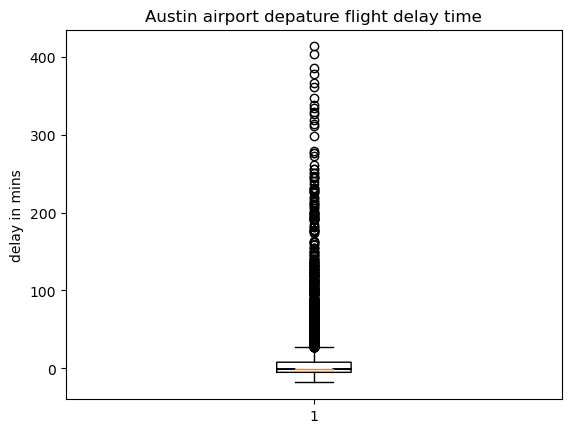

In [8]:
#clean data and plot again for outliner
cleandata =clean_df[clean_df['DELAY']<420]
plt.boxplot(cleandata.DELAY, notch=True)
plt.title('Austin airport depature flight delay time')
plt.ylabel('delay in mins')

###### looks like still have a lot variations. but most flights are with delay < 40 mins. I want to keep rest "outliners" since they are true delays.

###### I do not plan to do fuzzy matching. the data so far is quite clean. all string value is unique and meaningful. 

###### Step9. print out cleaned up data again. the name of dataframe is cleandata

In [9]:
#display first 20 rows. total has >7500 rows
cleandata.head(20)

,MONTH,DAY,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_TIME,DELAY,CANCELLED
0,1,1,OO,4986,AUS,LAX,535.0,-3.0,0
1,1,1,AA,1178,AUS,DFW,548.0,-2.0,0
2,1,1,B6,794,AUS,JFK,559.0,-1.0,0
3,1,1,OO,6235,AUS,SFO,556.0,-4.0,0
4,1,1,UA,572,AUS,IAH,658.0,28.0,0
5,1,1,DL,1984,AUS,ATL,625.0,-5.0,0
6,1,1,WN,795,AUS,ATL,637.0,-3.0,0
7,1,1,AA,1595,AUS,DFW,647.0,-3.0,0
8,1,1,WN,617,AUS,BWI,709.0,-1.0,0
9,1,1,B6,217,AUS,LGB,705.0,-7.0,0


###### Ethnical concerns and summary:
this is a dataset from real life flight information. So when doing data clean up and wrangling, it is necessary to know the meaning of each variable and its real life meaningful range. for example, a 3 hours delay is showed as an outliner, but in real life, it is quite possible. At the same time, a flight with 23 days delay is very unlikely not being cancelled. 

to make other team memaber to understand data, it is important the data resouce is legal, the data and wrangling steps are clean and readable. Since the data is from a government source, the data is quite clean and variable names are easy to understand. only minimum rename is conducted. 

since this is from a public domain, so the data security is not a concern as well. However, if I plan to use a data from a private resources, I may need to request permission to use it and share results. 

### End of milstone 2

In [11]:
cleandata.to_csv('departure.csv')